In [1]:
%matplotlib inline

from classes.DQNagentClass import DQNAgent, DDQNAgent
from utilities.plots import create_grids, plot_trajectory
from utilities.jsonRW import writeJSON

In [2]:
#Hyperparameters
show_stats = True      # show stats
export_to_JSON = False  # write JSON file
render = True           # render the results after training

NUM_DQN_AGENTS = 1      # number of DQN agents
NUM_DDQN_AGENTS = 1     # number of DDQN agents

NUM_NEURONS_FC1 = 128   # number of neurons for the first fully connected layer
NUM_NEURONS_FC2 = 128   # number of neurons for the second fully connected layer

SHAPE = "5x5"             # "5x5" or "14x14"
EPISODES_PER_AGENT = 1500
MAX_STEPS_PER_EPISODE = 200

EPS_START = 1.0         # epsilon start value
EPS_END = 0.01          # epsilon end value
EPS_DECAY = 0.996       # epsilon decay rate
#EPS_DECAY = EPS_START/(EPISODES_PER_AGENT/2)

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [3]:
#CREATING AND TRAINING THE AGENTS
agents_arr = []         # array of agents

for i in range(NUM_DQN_AGENTS+NUM_DDQN_AGENTS):
    if i < NUM_DQN_AGENTS:
        print("DQN Agent", i+1,"/",NUM_DQN_AGENTS)    # if the agent is a DQN agent
        path_to_save = "../data/agent_models/pytorch/DQNagent"+str(i+1)+".pt" # path to save the model
        agent = DQNAgent(i, path_to_save, SHAPE, NUM_NEURONS_FC1, NUM_NEURONS_FC2, EPISODES_PER_AGENT, MAX_STEPS_PER_EPISODE, EPS_START, EPS_END, EPS_DECAY, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY)
    else:
        print("DDQN Agent", i+1-NUM_DQN_AGENTS,"/",NUM_DDQN_AGENTS)  # if the agent is a DDQN agent 
        path_to_save = "../data/agent_models/pytorch/DDQNagent"+str(i+1)+".pt" # path to save the model
        agent = DDQNAgent(i, path_to_save, SHAPE, NUM_NEURONS_FC1, NUM_NEURONS_FC2, EPISODES_PER_AGENT, MAX_STEPS_PER_EPISODE, EPS_START, EPS_END, EPS_DECAY, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY)

    agent.train()
    agents_arr.append(agent)

DQN Agent 1 / 1


100%|██████████| 1500/1500 [00:40<00:00, 37.09it/s]


DDQN Agent 1 / 1


100%|██████████| 1500/1500 [00:40<00:00, 37.42it/s]


Agent 1 steps stats: 	Average: 20.4 	Std dev: 31.42 	Median: 9.0 	Best: 8


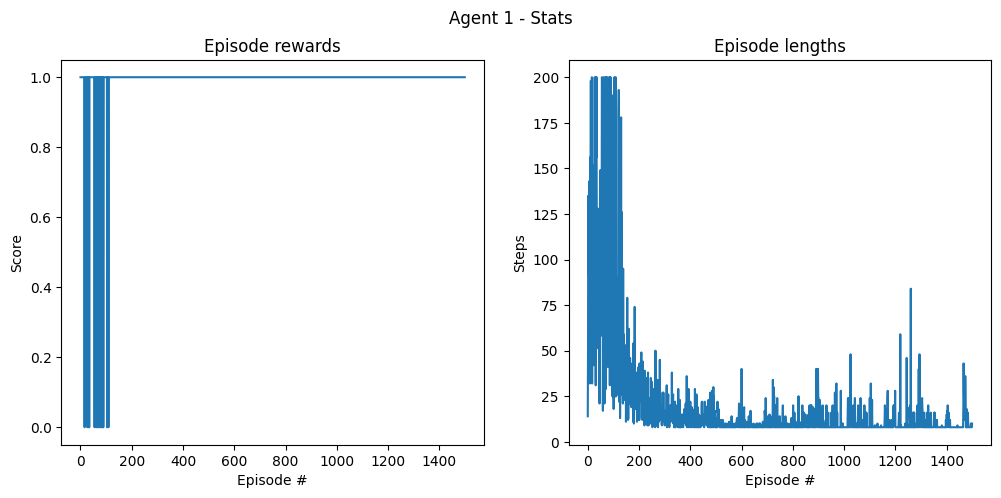

Agent 2 steps stats: 	Average: 19.62 	Std dev: 30.35 	Median: 8.0 	Best: 8


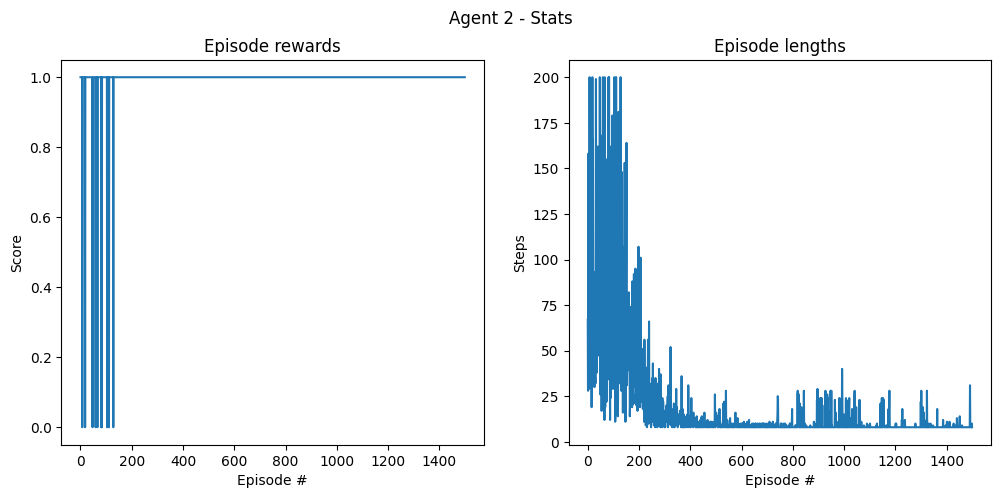

In [4]:
if show_stats:
    for agent in agents_arr:
        agent.plot_results(rolling_length=1)

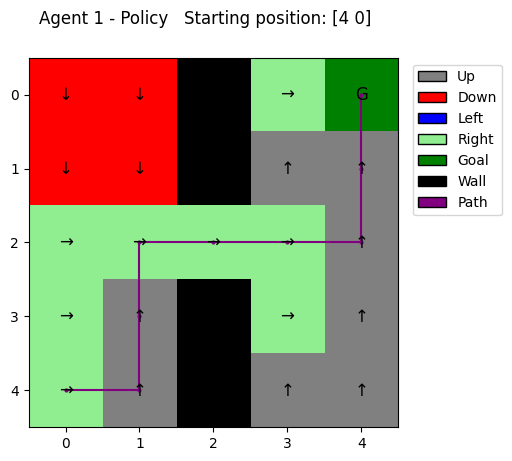

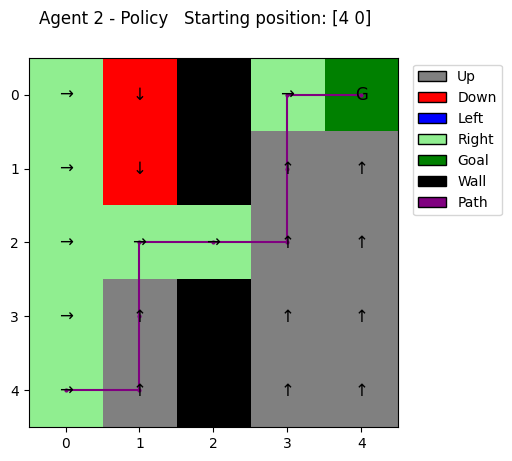

In [5]:
for agent in agents_arr:
    value_grid, policy_grid, string_policy_grid = create_grids(agent.env, Qnet=agent.qnetwork_local)
    start_pos = agent.env.unwrapped.start_pos

    if export_to_JSON:
        if i < NUM_DQN_AGENTS:
            algorithm = "DQN"
        else:
            algorithm = "DDQN"

        writeJSON(algorithm, EPISODES_PER_AGENT, MAX_STEPS_PER_EPISODE, SHAPE, start_pos, value_grid, policy_grid, string_policy_grid)
    
    if render:
        plot_trajectory(string_policy_grid, start_pos, agent.id)
